In [102]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [59]:
dfs = []
for i in range(1, 5):
    path = '/kaggle/input/unsw-nb15/UNSW-NB15_{}.csv'  # Note the use of raw string
    dfs.append(pd.read_csv(path.format(i), header=None))
combined_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

# Optionally, display the first few rows of the combined dataframe
print(combined_data.head())

           0      1              2     3    4    5         6    7    8   9   \
0  59.166.0.0   1390  149.171.126.6    53  udp  CON  0.001055  132  164  31   
1  59.166.0.0  33661  149.171.126.9  1024  udp  CON  0.036133  528  304  31   
2  59.166.0.6   1464  149.171.126.7    53  udp  CON  0.001119  146  178  31   
3  59.166.0.5   3593  149.171.126.5    53  udp  CON  0.001209  132  164  31   
4  59.166.0.3  49664  149.171.126.0    53  udp  CON  0.001169  146  178  31   

   ...  39  40  41 42  43  44  45  46   47  48  
0  ...   0   3   7  1   3   1   1   1  NaN   0  
1  ...   0   2   4  2   3   1   1   2  NaN   0  
2  ...   0  12   8  1   2   2   1   1  NaN   0  
3  ...   0   6   9  1   1   1   1   1  NaN   0  
4  ...   0   7   9  1   1   1   1   1  NaN   0  

[5 rows x 49 columns]


In [60]:
dataset_columns = pd.read_csv(r'/kaggle/input/unsw-nb15/NUSW-NB15_features.csv',encoding='ISO-8859-1')
dataset_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   No.          49 non-null     int64 
 1   Name         49 non-null     object
 2   Type         49 non-null     object
 3   Description  49 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


In [61]:
combined_data.columns = dataset_columns['Name']
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [63]:
combined_data['attack_cat'].isnull().sum()

2218764

# handling missing values

In [64]:
combined_data['attack_cat'] = combined_data['attack_cat'].fillna(value='normal').apply(lambda x: x.strip().lower())

In [65]:
combined_data['ct_flw_http_mthd'] = combined_data['ct_flw_http_mthd'].fillna(value=0)
combined_data['is_ftp_login'] = combined_data['is_ftp_login'].fillna(value=0)

In [66]:
combined_data['is_ftp_login'] = np.where(combined_data['is_ftp_login']>1, 1, combined_data['is_ftp_login'])

In [67]:
#combined_data['service'] = combined_data['servie'].replace(to_replace='-', value='None')
combined_data['service'] = combined_data['service'].apply(lambda x:"None" if x=='-' else x)
combined_data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3, '0', '1', ' ', '2', '4'], dtype=object)

In [68]:
combined_data['ct_ftp_cmd'] = combined_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)
combined_data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3])

# dropping irrelevent columns

In [69]:
combined_data.drop(columns=['srcip','sport','dstip','dsport','Label'],inplace=True)

In [70]:
import pandas as pd


combined_data['attack_cat'] = combined_data['attack_cat'].apply(
    lambda x: 'attack' if x.lower() != 'normal' else 'Normal'
)

# Vérifiez les remplacements
print(combined_data['attack_cat'].value_counts())

attack_cat
Normal    2218764
attack     321283
Name: count, dtype: int64


# data splitting

In [71]:
train, test = train_test_split(combined_data,test_size=0.2,random_state=16)
train, val = train_test_split(train,test_size=0.2,random_state=16)
train.shape, test.shape,val.shape

((1625629, 44), (508010, 44), (406408, 44))

# dropping attack-cat column

In [72]:
x_train, y_train = train.drop(columns=['attack_cat']), train[['attack_cat']]
x_test, y_test = test.drop(columns=['attack_cat']), test[['attack_cat']]
x_val, y_val = val.drop(columns=['attack_cat']), val[['attack_cat']]
x_train.shape, y_train.shape

((1625629, 43), (1625629, 1))

In [73]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))
train.head()

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
1070804,tcp,FIN,0.438857,4776,3080,31,29,7,7,None,...,0.0,0,6,3,4,5,1,1,3,Normal
1054569,tcp,CON,0.026163,2230,13900,31,29,7,10,None,...,0.0,0,2,7,2,1,1,1,1,Normal
1548299,tcp,FIN,0.014954,2854,26584,31,29,7,16,None,...,0.0,0,9,6,4,8,1,1,1,Normal
2305760,udp,INT,0.000009,114,0,254,0,0,0,dns,...,0.0,0,33,33,17,17,17,17,33,attack
1989356,udp,CON,0.001562,544,304,31,29,0,0,None,...,0.0,0,6,7,5,6,1,1,3,Normal


In [74]:
num_col = train.select_dtypes(include=['number']).columns

# correlation Map of features

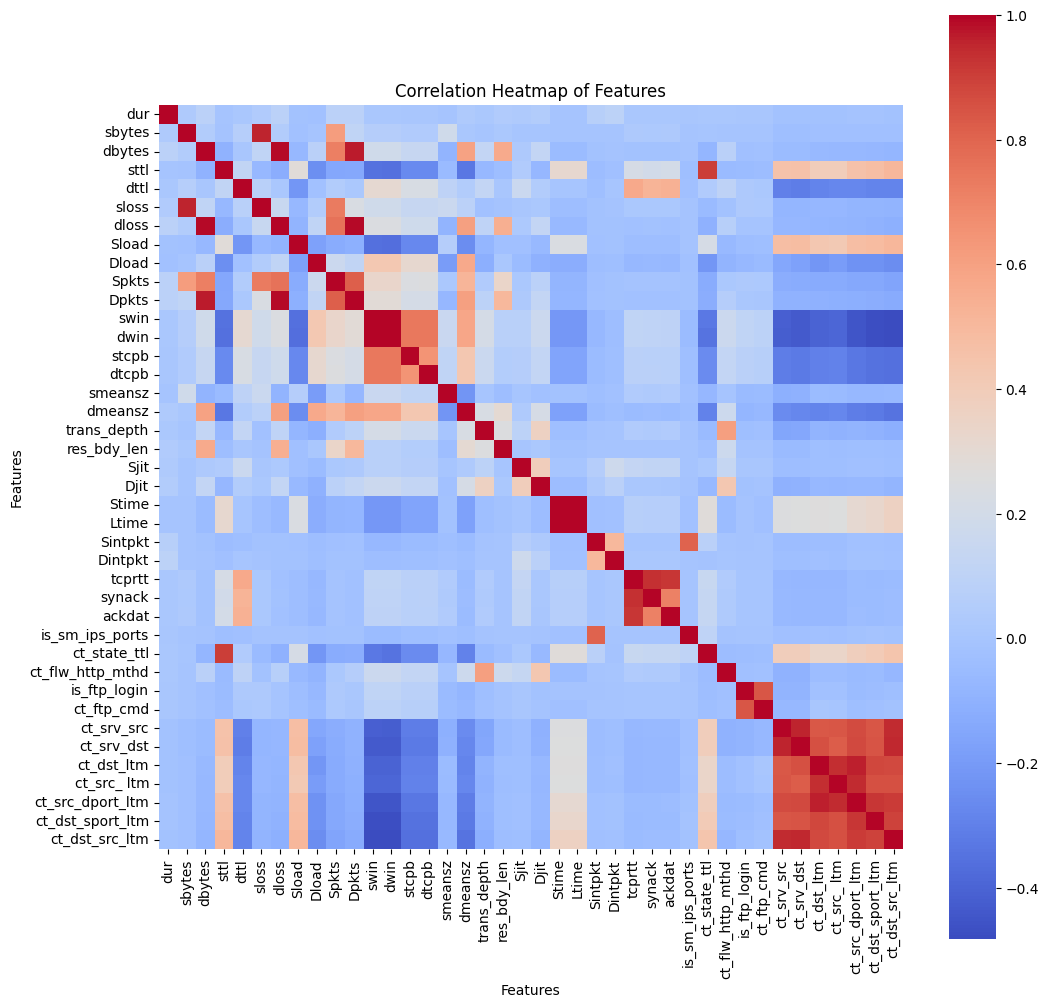

In [75]:
correlation_matrix = train[num_col].corr()


plt.figure(figsize=(12, 12))  


sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap of Features')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

# distribution of samples

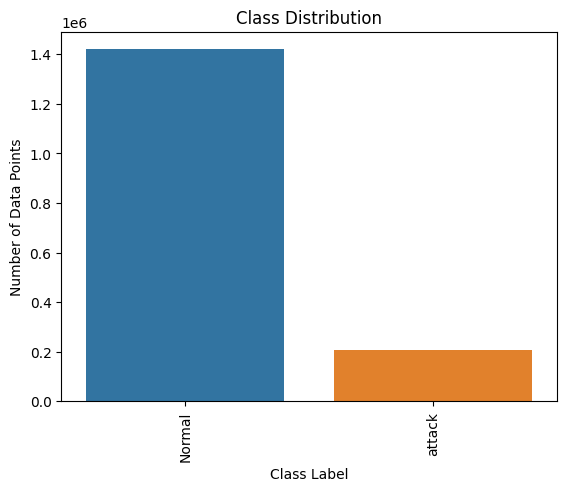

In [76]:
labels = train['attack_cat']

# Create a count plot with Seaborn
sns.countplot(x=labels)

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Number of Data Points')
plt.title('Class Distribution')

# Rotate x-axis labels for better readability if there are many classes
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [77]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])
x_train[num_col] = scaler.transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])
x_val[num_col] = scaler.transform(x_val[num_col])

In [78]:
x_train.isnull().sum()


Name
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
Sload               0
Dload               0
Spkts               0
Dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
Sjit                0
Djit                0
Stime               0
Ltime               0
Sintpkt             0
Dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ ltm         0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
dtype: int64

# label Encoding

In [79]:
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_col)], 
    remainder='passthrough'
)
x_train = np.array(ct.fit_transform(x_train))
x_test = np.array(ct.transform(x_test))
x_val = np.array(ct.transform(x_val))

In [80]:
attacks = y_train['attack_cat'].unique()
ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(categories=[attacks],sparse_output=False), ['attack_cat'])], remainder='passthrough')
y_train = np.array(ct1.fit_transform(y_train))
y_test = np.array(ct1.transform(y_test))
y_val = np.array(ct1.transform(y_val))

In [90]:
x_train.shape

(1625629, 204)

In [91]:
x_train.reshape(-1,1).shape

(331628316, 1)

In [92]:
# Define model parameters
n_features = x_train.shape[1]  # Number of features in the training data

# Define the model
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=6, kernel_size=1, activation='relu', input_shape=(n_features, 1), kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# LSTM block
model.add(LSTM(units=8, return_sequences=True, kernel_regularizer=l2(0.001)))

# Second convolutional block
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Flatten the LSTM output
model.add(Flatten())

# Dense layers
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(2, activation='softmax'))

# Learning rate and optimizer
learning_rate = 0.00001  # Reduced learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_31 (Conv1D)              │ (None, 204, 6)         │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 102, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 102, 6)         │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 102, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 102, 8)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 100, 16)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,678 (104.21 KB)

 Trainable params: 26,634 (104.04 KB)

 Non-trainable params: 44 (176.00 B)

# Model Training

In [99]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 68s 11ms/step - accuracy: 0.9418 - loss: 0.2153 - precision_11: 0.9418 - recall_11: 0.9418 - val_accuracy: 0.9819 - val_loss: 0.1135 - val_precision_11: 0.9819 - val_recall_11: 0.9819 - learning_rate: 1.0000e-05
Epoch 3/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 68s 11ms/step - accuracy: 0.9560 - loss: 0.1727 - precision_11: 0.9560 - recall_11: 0.9560 - val_accuracy: 0.9798 - val_loss: 0.0986 - val_precision_11: 0.9798 - val_recall_11: 0.9798 - learning_rate: 1.0000e-05
Epoch 4/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - accuracy: 0.9630 - loss: 0.1473 - precision_11: 0.9630 - recall_11: 0.9630 - val_accuracy: 0.9791 - val_loss: 0.0890 - val_precision_11: 0.9791 - val_recall_11: 0.9791 - learning_rate: 1.0000e-05
Epoch 5/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - accuracy: 0.9666 - loss: 0.1299 - precision_11: 0.9666 - recall_11: 0.9666 - val_accuracy: 0.9822 - val_loss: 0.0821 - val_precision_11: 0.9822 - val_recall_11: 0.9822 - learning_rate:

# Model Testing

In [100]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9820 - loss: 0.0828 - precision_11: 0.9820 - recall_11: 0.9820
Test Loss: 0.08208112418651581
Test Accuracy: 0.9823153018951416
Test Precision: 0.9823153018951416
Test Recall: 0.9823153018951416


# F1-score

In [104]:
from sklearn.metrics import f1_score
y_pred = model.predict(x_test) 
# Convertir les prédictions en labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculer le F1-score
f1 = f1_score(y_test.argmax(axis=1), y_pred_labels, average='weighted')

print("F1-Score:", f1)

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step
F1-Score: 0.9827773351983659


# Training graphs

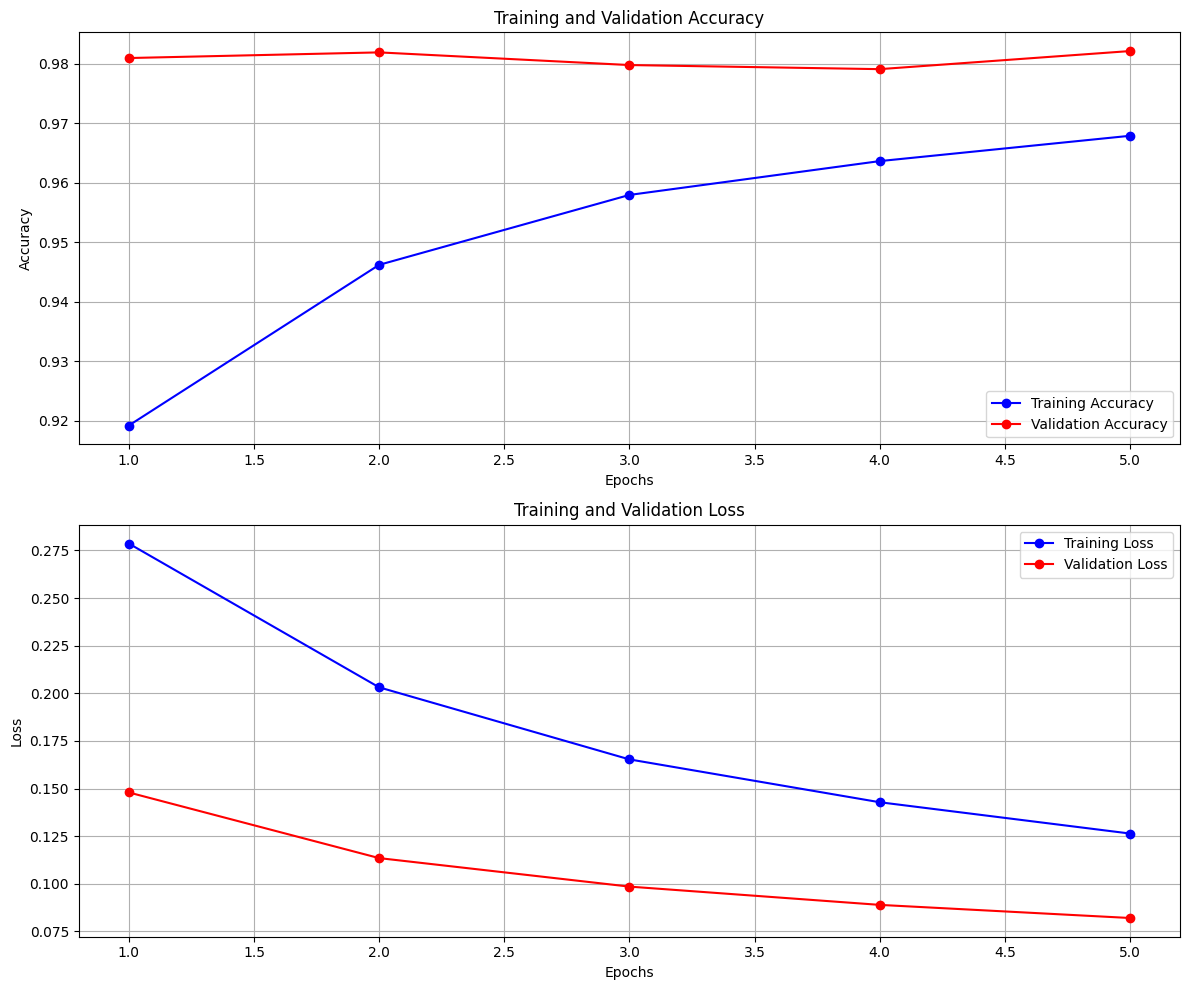

In [106]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Define epochs
epochs = range(1, len(train_accuracy) + 1)

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot training and validation accuracy
ax1.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid()

# Plot training and validation loss
ax2.plot(epochs, train_loss, 'bo-', label='Training Loss')
ax2.plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid()

# Show the plots
plt.tight_layout()
plt.show()


# Confusion Matrix

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step


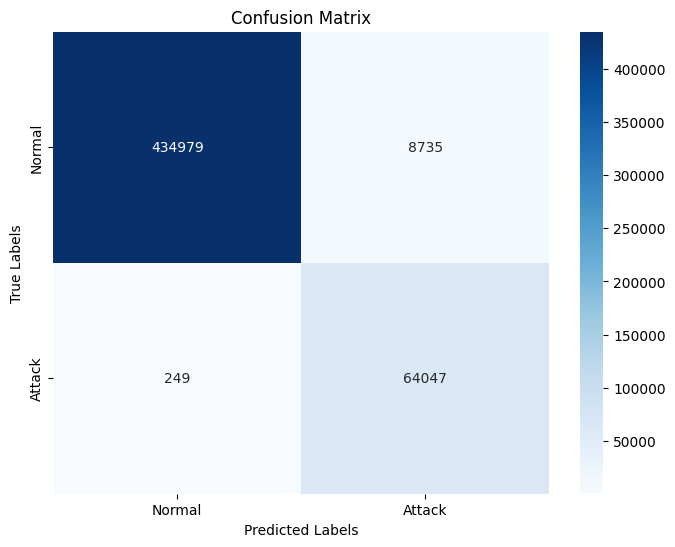

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Update labels for binary classification
labels = ['Normal', 'Attack']  

# Step 2: Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert model output to class indices for binary classification
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class indices if needed

# Step 3: Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 4: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# ROC

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step


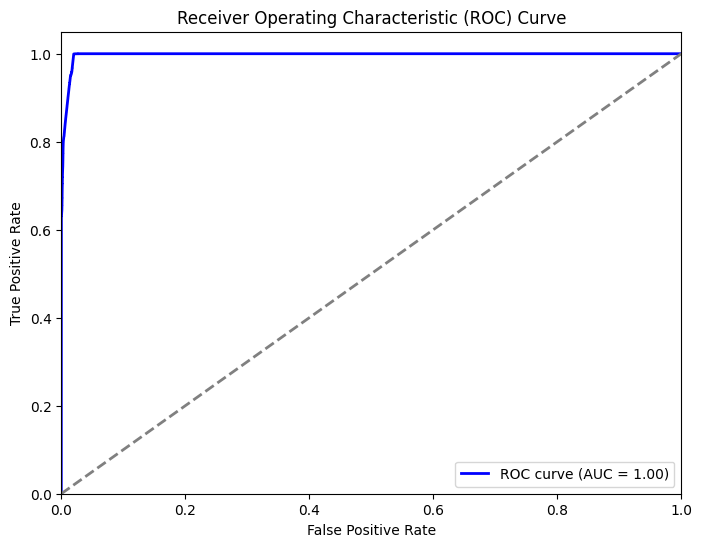

In [108]:
from sklearn.metrics import roc_curve, auc

# Step 1: Predict probabilities for the positive class (Normal)
y_pred_prob = model.predict(x_test)[:, 1]  # Probability of the positive class

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_prob)  # Use the actual labels and predicted probabilities
roc_auc = auc(fpr, tpr)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
